# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch
import time

random.seed(42)

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [2]:
# Normalize images

'''data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])'''

data_aug = transforms.Compose([
    transforms.ToPILImage(),    
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]

        '''self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)'''

        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1).float()

        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i]

        '''return image, num_pieces.float()'''
        return image, num_pieces.view(-1,1)

train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 6479
Number of valid images: 2192
Number of test images: 2129


In [4]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 32
num_workers = 0

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([32, 224, 224, 3])
torch.Size([32, 1, 1])
tensor(1)


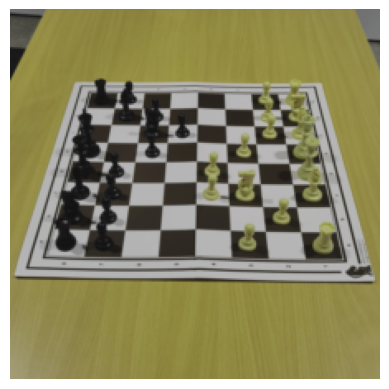

In [5]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?

# **Now trying new approach with a different model**



## Defining the model

We will use a pre-trained ResNet50 network.

In [6]:
from torchvision.models import efficientnet_b0
import torchvision

# First we started with EfficientNet-B0
# Using ScaledSigmoid activation function for the final layer so the CNN knows the output is a number between 0 and 32 (number of pieces on the board)

class ScaledSigmoid(nn.Module):
    def __init__(self, scale=32.0):
        super(ScaledSigmoid, self).__init__()
        self.scale = scale

    def forward(self, x):
        return torch.sigmoid(x) * self.scale

# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# # Load pretrained EfficientNet-B0
model = efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)

model.classifier[1] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    ScaledSigmoid(scale=32.0)  # Using ScaledSigmoid to output a number between 0 and 32
)

# Move model to device
model.to(device)

# Define loss function 
loss_fn = nn.HuberLoss() # nn.MSELoss() or nn.L1Loss() can also be used

Using cuda device


## Train the model

Define function to perform one iteration

In [10]:
def accuracy_tolerance(outputs, labels, tol=1):
    preds = torch.round(outputs)
    correct = (torch.abs(preds - labels) <= tol).float()
    return correct.mean().item()

def train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True):
    model.train() if is_train else model.eval()
    
    images = images.to(device, non_blocking=True)
    labels = labels.to(device).float().view(-1, 1)

    with torch.set_grad_enabled(is_train):
        outputs = model(images)
        loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad(set_to_none=True)  # More memory efficient
            loss.backward()
            optimizer.step()

    return loss.item(), outputs.detach()

Define function to train a model

In [9]:
def evaluate(loader, model, criterion, device):
    model.eval()
    running_loss = 0.
    running_mae = 0.
    running_acc = 0.
    running_mse = 0.
    total_samples = 0

    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(images)

            loss = criterion(outputs, labels)
            mae = F.l1_loss(outputs, labels)
            mse = F.mse_loss(outputs, labels)
            acc = accuracy_tolerance(outputs, labels)

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            running_mae += mae.item() * batch_size
            running_acc += acc * batch_size
            running_mse += mse.item() * batch_size
            total_samples += batch_size

            all_labels.append(labels.cpu())
            all_outputs.append(outputs.cpu())

    all_labels = torch.cat(all_labels).squeeze()
    all_outputs = torch.cat(all_outputs).squeeze()

    ss_res = torch.sum((all_labels - all_outputs) ** 2)
    ss_tot = torch.sum((all_labels - torch.mean(all_labels)) ** 2)
    r2 = 1 - ss_res / ss_tot

    avg_loss = running_loss / total_samples
    avg_mae = running_mae / total_samples
    avg_acc = running_acc / total_samples
    avg_mse = running_mse / total_samples
    avg_rmse = avg_mse ** 0.5

    return avg_loss, avg_mae, avg_acc, avg_mse, avg_rmse, r2.item()


In [10]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, scheduler=None, num_epochs=10):
    best_val_loss = float('inf')
    best_model_path = 'best_model.pth'

    # Train Metrics: loss, mae, acc±1 (accuracy within tolerance of 1), only 3 metrics for low cost training
    train_history = {'loss': [], 'mae': [], 'acc±1': []}
    # Validation Metrics: loss, mae, acc±1, mse, rmse, r2, all 6 metrics for comprehensive evaluation
    val_history = {'loss': [], 'mae': [], 'acc±1': [], 'mse': [], 'rmse': [], 'r2': []}

    total_train_time = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        epoch_start_time = time.time()

        # ===== TRAINING =====
        model.train()
        running_loss = 0.0
        running_mae = 0.0
        running_acc = 0.0
        total_samples = 0

        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in train_bar:
            loss, outputs = train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True)

            labels = labels.to(device).float().view(-1, 1)
            mae = F.l1_loss(outputs, labels)
            acc = accuracy_tolerance(outputs, labels)

            batch_size = labels.size(0)
            running_loss += loss * batch_size
            running_mae += mae.item() * batch_size
            running_acc += acc * batch_size
            total_samples += batch_size

            train_bar.set_postfix(loss=running_loss/total_samples, MAE=running_mae/total_samples, acc=f"{(running_acc/total_samples)*100:.2f}%")

        train_loss = running_loss / total_samples
        train_mae = running_mae / total_samples
        train_acc = running_acc / total_samples

        train_history['loss'].append(train_loss)
        train_history['mae'].append(train_mae)
        train_history['acc±1'].append(train_acc)

        print(f"✔️ Train Loss: {train_loss:.4f} | Train MAE: {train_mae:.4f} | Train Acc±1: {train_acc*100:.2f}%")

        epoch_time = time.time() - epoch_start_time
        total_train_time += epoch_time
        print(f"Epoch {epoch+1} took {epoch_time:.2f} seconds.")

        # ===== VALIDATION =====
        if val_loader:
            val_loss, val_mae, val_acc, val_mse, val_rmse, val_r2 = evaluate(val_loader, model, criterion, device)

            val_history['loss'].append(val_loss)
            val_history['mae'].append(val_mae)
            val_history['acc±1'].append(val_acc)
            val_history['mse'].append(val_mse)
            val_history['rmse'].append(val_rmse)
            val_history['r2'].append(val_r2)

            print(f"🔍 Validation Loss: {val_loss:.4f} | MAE: {val_mae:.4f} | Acc±1: {val_acc*100:.2f}% | MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | R2: {val_r2:.4f}")

            # Save the best model based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"💾 Best model saved with val loss: {best_val_loss:.4f}")

            # Update the learning rate if using a scheduler
            if scheduler:
                scheduler.step(val_loss)

    print(f"\nTotal training time: {total_train_time:.2f} seconds.")
    return train_history, val_history, total_train_time


Define loss, optimizer and train the model

In [11]:
def plot_training_history(train_history, val_history):
    plt.figure(figsize=(16, 10))

    # Loss
    plt.subplot(2, 3, 1)
    plt.plot(train_history['loss'], label='Train Loss')
    plt.plot(val_history['loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MAE
    plt.subplot(2, 3, 2)
    plt.plot(train_history['mae'], label='Train MAE')
    plt.plot(val_history['mae'], label='Val MAE')
    plt.title('MAE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    # Accuracy ±1
    plt.subplot(2, 3, 3)
    plt.plot(train_history['acc±1'], label='Train Acc ±1')
    plt.plot(val_history['acc±1'], label='Val Acc ±1')
    plt.title('Accuracy ±1 over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy ±1')
    plt.legend()

    # MSE (Validation only)
    plt.subplot(2, 3, 4)
    plt.plot(val_history['mse'], label='Val MSE', color='orange')
    plt.title('Validation MSE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # RMSE (Validation only)
    plt.subplot(2, 3, 5)
    plt.plot(val_history['rmse'], label='Val RMSE', color='green')
    plt.title('Validation RMSE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()

    # R² (Validation only)
    plt.subplot(2, 3, 6)
    plt.plot(val_history['r2'], label='Val R²', color='red')
    plt.title('Validation R² over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.legend()

    plt.tight_layout()
    plt.show()


## **Try another approach for freezing/unfreezing layers**


In [12]:
# Get total number of blocks in model.features
total_blocks = len(list(model.features))

def unfreeze_blocks(model, n):
    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False
    
    # Always unfreeze classifier
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    # Unfreeze last n blocks in features
    if n > 0:
        if hasattr(model, 'features') and isinstance(model.features, nn.Sequential):
            features_blocks = list(model.features)
            for block in features_blocks[-n:]:
                for param in block.parameters():
                    param.requires_grad = True
        else:
            raise ValueError("Model.features is not an nn.Sequential or not present.")

def is_stuck(val_losses, patience=3, min_delta=1e-3):
    if len(val_losses) < patience + 1:
        return False
    # Check if the average improvement in last 'patience' steps is less than min_delta
    recent = val_losses[-(patience+1):]
    improvements = [recent[i] - recent[i+1] for i in range(patience)]
    avg_improvement = sum(improvements) / patience
    return avg_improvement < min_delta

# Training parameters
num_epochs_per_step = 3
max_unfreeze_blocks = total_blocks
blocks_to_unfreeze_each_step = 1  # Unfreeze one block at a time
current_unfreeze_blocks = 1  # Start with 1 block unfrozen

max_total_epochs = 100
epochs_trained = 0

# Initialize with first block unfrozen
unfreeze_blocks(model, current_unfreeze_blocks)

# Setup optimizer with all trainable parameters
params_to_optimize = [
    {'params': model.classifier.parameters(), 'lr': 1e-3},
    {'params': [p for block in list(model.features)[-current_unfreeze_blocks:] 
               for p in block.parameters()], 'lr': 1e-4}
]
optimizer = optim.AdamW(params_to_optimize, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training history
train_history_all = {'loss': [], 'mae': [], 'acc±1': []}
val_history_all = {'loss': [], 'mae': [], 'acc±1': [], 'mse': [], 'rmse': [], 'r2': []}

while current_unfreeze_blocks <= max_unfreeze_blocks and epochs_trained < max_total_epochs:
    print(f"\n=== Training with last {current_unfreeze_blocks} blocks unfrozen ===")
    
    # Train model
    train_hist, val_hist, epoch_time = train_model(
        model, train_dataloader, valid_dataloader,
        optimizer, loss_fn, device,
        scheduler=scheduler,
        num_epochs=num_epochs_per_step
    )
    
    # Update histories
    for key in train_history_all:
        train_history_all[key].extend(train_hist.get(key, []))
    for key in val_history_all:
        val_history_all[key].extend(val_hist.get(key, []))
    
    epochs_trained += num_epochs_per_step
    
    # Check if we should unfreeze more blocks
    if len(val_history_all['loss']) >= 4 and is_stuck(val_history_all['loss']):
        new_unfreeze = min(current_unfreeze_blocks + blocks_to_unfreeze_each_step, max_unfreeze_blocks)
        
        if new_unfreeze > current_unfreeze_blocks:
            print(f"Unfreezing more blocks: from {current_unfreeze_blocks} to {new_unfreeze}")
            current_unfreeze_blocks = new_unfreeze
            unfreeze_blocks(model, current_unfreeze_blocks)
            
            # Create new optimizer with updated parameters
            params_to_optimize = [
                {'params': model.classifier.parameters(), 'lr': 1e-3},
                {'params': [p for block in list(model.features)[-current_unfreeze_blocks:] 
                          for p in block.parameters()], 'lr': 1e-4}
            ]
            
            # Save optimizer state
            old_state = optimizer.state_dict()
            
            # Create new optimizer
            optimizer = optim.AdamW(params_to_optimize, weight_decay=1e-4)
            
            # Transfer state for existing parameters
            new_state = optimizer.state_dict()
            for param in old_state['state']:
                if param in new_state['state']:
                    new_state['state'][param] = old_state['state'][param]
            optimizer.load_state_dict(new_state)
            
            # Reset scheduler with new optimizer
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=2
            )
        else:
            print("All blocks already unfrozen. Continuing training.")
    
    # Early stopping if validation loss is NaN or very high
    if len(val_history_all['loss']) > 0 and (np.isnan(val_history_all['loss'][-1]) or val_history_all['loss'][-1] > 1e3):
        print("Validation loss exploded. Stopping training.")
        break

print(f"\nTraining finished. Total epochs: {epochs_trained}")


=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 3.5448 | Train MAE: 4.0155 | Train Acc±1: 25.82%
Epoch 1 took 904.67 seconds.
🔍 Validation Loss: 2.0098 | MAE: 2.4569 | Acc±1: 42.61% | MSE: 10.7537 | RMSE: 3.2793 | R2: 0.8475
💾 Best model saved with val loss: 2.0098

Epoch 2/3


✔️ Train Loss: 2.8562 | Train MAE: 3.3167 | Train Acc±1: 31.50%
Epoch 2 took 889.39 seconds.
🔍 Validation Loss: 2.1198 | MAE: 2.5688 | Acc±1: 38.91% | MSE: 11.0881 | RMSE: 3.3299 | R2: 0.8428

Epoch 3/3


✔️ Train Loss: 2.6230 | Train MAE: 3.0798 | Train Acc±1: 34.47%
Epoch 3 took 892.97 seconds.
🔍 Validation Loss: 1.8109 | MAE: 2.2501 | Acc±1: 43.48% | MSE: 8.7853 | RMSE: 2.9640 | R2: 0.8754
💾 Best model saved with val loss: 1.8109

Total training time: 2687.03 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 2.4956 | Train MAE: 2.9467 | Train Acc±1: 35.67%
Epoch 1 took 893.88 seconds.
🔍 Validation Loss: 1.7624 | MAE: 2.1989 | Acc±1: 44.34% | MSE: 8.3891 | RMSE: 2.8964 | R2: 0.8810
💾 Best model saved with val loss: 1.7624

Epoch 2/3


✔️ Train Loss: 2.4583 | Train MAE: 2.9084 | Train Acc±1: 35.66%
Epoch 2 took 887.23 seconds.
🔍 Validation Loss: 1.6056 | MAE: 2.0410 | Acc±1: 47.54% | MSE: 7.2853 | RMSE: 2.6991 | R2: 0.8967
💾 Best model saved with val loss: 1.6056

Epoch 3/3


✔️ Train Loss: 2.3002 | Train MAE: 2.7476 | Train Acc±1: 37.89%
Epoch 3 took 888.43 seconds.
🔍 Validation Loss: 1.6322 | MAE: 2.0676 | Acc±1: 48.31% | MSE: 7.4865 | RMSE: 2.7361 | R2: 0.8938

Total training time: 2669.54 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 2.2336 | Train MAE: 2.6783 | Train Acc±1: 38.92%
Epoch 1 took 888.77 seconds.
🔍 Validation Loss: 1.5657 | MAE: 1.9913 | Acc±1: 49.00% | MSE: 7.1860 | RMSE: 2.6807 | R2: 0.8981
💾 Best model saved with val loss: 1.5657

Epoch 2/3


✔️ Train Loss: 2.1344 | Train MAE: 2.5781 | Train Acc±1: 39.94%
Epoch 2 took 888.80 seconds.
🔍 Validation Loss: 1.4958 | MAE: 1.9234 | Acc±1: 49.13% | MSE: 6.4002 | RMSE: 2.5299 | R2: 0.9092
💾 Best model saved with val loss: 1.4958

Epoch 3/3


✔️ Train Loss: 2.0779 | Train MAE: 2.5207 | Train Acc±1: 40.28%
Epoch 3 took 888.11 seconds.
🔍 Validation Loss: 1.4458 | MAE: 1.8730 | Acc±1: 51.46% | MSE: 6.1627 | RMSE: 2.4825 | R2: 0.9126
💾 Best model saved with val loss: 1.4458

Total training time: 2665.67 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 2.1228 | Train MAE: 2.5643 | Train Acc±1: 39.37%
Epoch 1 took 889.62 seconds.
🔍 Validation Loss: 1.4774 | MAE: 1.8998 | Acc±1: 50.05% | MSE: 6.4505 | RMSE: 2.5398 | R2: 0.9085
💾 Best model saved with val loss: 1.4774

Epoch 2/3


✔️ Train Loss: 2.0999 | Train MAE: 2.5443 | Train Acc±1: 39.63%
Epoch 2 took 888.93 seconds.
🔍 Validation Loss: 1.4682 | MAE: 1.8970 | Acc±1: 49.32% | MSE: 6.0890 | RMSE: 2.4676 | R2: 0.9137
💾 Best model saved with val loss: 1.4682

Epoch 3/3


✔️ Train Loss: 2.0141 | Train MAE: 2.4547 | Train Acc±1: 41.46%
Epoch 3 took 891.16 seconds.
🔍 Validation Loss: 1.4391 | MAE: 1.8682 | Acc±1: 50.23% | MSE: 6.0012 | RMSE: 2.4497 | R2: 0.9149
💾 Best model saved with val loss: 1.4391

Total training time: 2669.70 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 2.0573 | Train MAE: 2.5016 | Train Acc±1: 40.56%
Epoch 1 took 889.90 seconds.
🔍 Validation Loss: 1.3943 | MAE: 1.8224 | Acc±1: 51.92% | MSE: 5.7842 | RMSE: 2.4050 | R2: 0.9180
💾 Best model saved with val loss: 1.3943

Epoch 2/3


✔️ Train Loss: 1.9641 | Train MAE: 2.4037 | Train Acc±1: 41.51%
Epoch 2 took 891.30 seconds.
🔍 Validation Loss: 1.4335 | MAE: 1.8565 | Acc±1: 50.87% | MSE: 6.0773 | RMSE: 2.4652 | R2: 0.9138

Epoch 3/3


✔️ Train Loss: 2.0110 | Train MAE: 2.4526 | Train Acc±1: 41.65%
Epoch 3 took 890.50 seconds.
🔍 Validation Loss: 1.3259 | MAE: 1.7514 | Acc±1: 53.79% | MSE: 5.3202 | RMSE: 2.3066 | R2: 0.9246
💾 Best model saved with val loss: 1.3259

Total training time: 2671.69 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.8887 | Train MAE: 2.3251 | Train Acc±1: 42.82%
Epoch 1 took 892.18 seconds.
🔍 Validation Loss: 1.5053 | MAE: 1.9372 | Acc±1: 49.22% | MSE: 6.3628 | RMSE: 2.5225 | R2: 0.9098
💾 Best model saved with val loss: 1.5053

Epoch 2/3


✔️ Train Loss: 1.9127 | Train MAE: 2.3503 | Train Acc±1: 43.39%
Epoch 2 took 889.55 seconds.
🔍 Validation Loss: 1.3789 | MAE: 1.7987 | Acc±1: 52.46% | MSE: 5.7288 | RMSE: 2.3935 | R2: 0.9188
💾 Best model saved with val loss: 1.3789

Epoch 3/3


✔️ Train Loss: 1.9136 | Train MAE: 2.3508 | Train Acc±1: 42.87%
Epoch 3 took 893.30 seconds.
🔍 Validation Loss: 1.2847 | MAE: 1.7055 | Acc±1: 54.29% | MSE: 5.0954 | RMSE: 2.2573 | R2: 0.9277
💾 Best model saved with val loss: 1.2847

Total training time: 2675.04 seconds.

=== Training with last 1 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.8744 | Train MAE: 2.3118 | Train Acc±1: 42.74%
Epoch 1 took 893.87 seconds.
🔍 Validation Loss: 1.2762 | MAE: 1.6985 | Acc±1: 54.20% | MSE: 5.0336 | RMSE: 2.2436 | R2: 0.9286
💾 Best model saved with val loss: 1.2762

Epoch 2/3


✔️ Train Loss: 1.8914 | Train MAE: 2.3289 | Train Acc±1: 42.96%
Epoch 2 took 892.96 seconds.
🔍 Validation Loss: 1.3039 | MAE: 1.7244 | Acc±1: 53.06% | MSE: 5.1628 | RMSE: 2.2722 | R2: 0.9268

Epoch 3/3


✔️ Train Loss: 1.8644 | Train MAE: 2.3032 | Train Acc±1: 43.08%
Epoch 3 took 891.92 seconds.
🔍 Validation Loss: 1.3547 | MAE: 1.7769 | Acc±1: 53.24% | MSE: 5.5456 | RMSE: 2.3549 | R2: 0.9214

Total training time: 2678.75 seconds.
Unfreezing more blocks: from 1 to 2

=== Training with last 2 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.7964 | Train MAE: 2.2321 | Train Acc±1: 44.69%
Epoch 1 took 893.57 seconds.
🔍 Validation Loss: 1.2968 | MAE: 1.7132 | Acc±1: 52.92% | MSE: 5.1071 | RMSE: 2.2599 | R2: 0.9276
💾 Best model saved with val loss: 1.2968

Epoch 2/3


✔️ Train Loss: 1.7617 | Train MAE: 2.1972 | Train Acc±1: 44.35%
Epoch 2 took 893.51 seconds.
🔍 Validation Loss: 1.2094 | MAE: 1.6276 | Acc±1: 56.66% | MSE: 4.6741 | RMSE: 2.1620 | R2: 0.9337
💾 Best model saved with val loss: 1.2094

Epoch 3/3


✔️ Train Loss: 1.6067 | Train MAE: 2.0364 | Train Acc±1: 47.82%
Epoch 3 took 892.88 seconds.
🔍 Validation Loss: 1.1708 | MAE: 1.5891 | Acc±1: 57.12% | MSE: 4.3767 | RMSE: 2.0921 | R2: 0.9379
💾 Best model saved with val loss: 1.1708

Total training time: 2679.96 seconds.

=== Training with last 2 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.5825 | Train MAE: 2.0127 | Train Acc±1: 48.02%
Epoch 1 took 893.31 seconds.
🔍 Validation Loss: 1.1297 | MAE: 1.5463 | Acc±1: 58.71% | MSE: 4.2059 | RMSE: 2.0508 | R2: 0.9404
💾 Best model saved with val loss: 1.1297

Epoch 2/3


✔️ Train Loss: 1.5620 | Train MAE: 1.9888 | Train Acc±1: 48.11%
Epoch 2 took 892.79 seconds.
🔍 Validation Loss: 1.1205 | MAE: 1.5318 | Acc±1: 57.80% | MSE: 4.1699 | RMSE: 2.0420 | R2: 0.9409
💾 Best model saved with val loss: 1.1205

Epoch 3/3


✔️ Train Loss: 1.4564 | Train MAE: 1.8815 | Train Acc±1: 50.31%
Epoch 3 took 895.64 seconds.
🔍 Validation Loss: 1.1158 | MAE: 1.5249 | Acc±1: 58.30% | MSE: 4.0955 | RMSE: 2.0237 | R2: 0.9419
💾 Best model saved with val loss: 1.1158

Total training time: 2681.74 seconds.

=== Training with last 2 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.4762 | Train MAE: 1.9022 | Train Acc±1: 49.26%
Epoch 1 took 895.36 seconds.
🔍 Validation Loss: 1.0542 | MAE: 1.4662 | Acc±1: 59.35% | MSE: 3.6864 | RMSE: 1.9200 | R2: 0.9477
💾 Best model saved with val loss: 1.0542

Epoch 2/3


✔️ Train Loss: 1.4230 | Train MAE: 1.8484 | Train Acc±1: 51.07%
Epoch 2 took 892.98 seconds.
🔍 Validation Loss: 1.0219 | MAE: 1.4255 | Acc±1: 61.54% | MSE: 3.6766 | RMSE: 1.9175 | R2: 0.9479
💾 Best model saved with val loss: 1.0219

Epoch 3/3


✔️ Train Loss: 1.4021 | Train MAE: 1.8283 | Train Acc±1: 51.31%
Epoch 3 took 894.35 seconds.
🔍 Validation Loss: 1.0494 | MAE: 1.4577 | Acc±1: 60.72% | MSE: 3.7502 | RMSE: 1.9365 | R2: 0.9468

Total training time: 2682.69 seconds.

=== Training with last 2 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.3941 | Train MAE: 1.8166 | Train Acc±1: 51.98%
Epoch 1 took 893.40 seconds.
🔍 Validation Loss: 1.0351 | MAE: 1.4434 | Acc±1: 60.86% | MSE: 3.6535 | RMSE: 1.9114 | R2: 0.9482
💾 Best model saved with val loss: 1.0351

Epoch 2/3


✔️ Train Loss: 1.3625 | Train MAE: 1.7864 | Train Acc±1: 52.41%
Epoch 2 took 896.90 seconds.
🔍 Validation Loss: 0.9872 | MAE: 1.3898 | Acc±1: 62.86% | MSE: 3.4273 | RMSE: 1.8513 | R2: 0.9514
💾 Best model saved with val loss: 0.9872

Epoch 3/3


✔️ Train Loss: 1.2952 | Train MAE: 1.7135 | Train Acc±1: 53.96%
Epoch 3 took 895.95 seconds.
🔍 Validation Loss: 0.9949 | MAE: 1.3948 | Acc±1: 63.55% | MSE: 3.5188 | RMSE: 1.8758 | R2: 0.9501

Total training time: 2686.25 seconds.

=== Training with last 2 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.2995 | Train MAE: 1.7190 | Train Acc±1: 53.67%
Epoch 1 took 895.91 seconds.
🔍 Validation Loss: 1.0016 | MAE: 1.4125 | Acc±1: 62.27% | MSE: 3.4284 | RMSE: 1.8516 | R2: 0.9514
💾 Best model saved with val loss: 1.0016

Epoch 2/3


✔️ Train Loss: 1.2763 | Train MAE: 1.6948 | Train Acc±1: 54.08%
Epoch 2 took 894.58 seconds.
🔍 Validation Loss: 0.9966 | MAE: 1.4037 | Acc±1: 62.09% | MSE: 3.4239 | RMSE: 1.8504 | R2: 0.9514
💾 Best model saved with val loss: 0.9966

Epoch 3/3


✔️ Train Loss: 1.2625 | Train MAE: 1.6810 | Train Acc±1: 54.73%
Epoch 3 took 893.46 seconds.
🔍 Validation Loss: 0.9674 | MAE: 1.3675 | Acc±1: 63.69% | MSE: 3.3751 | RMSE: 1.8371 | R2: 0.9521
💾 Best model saved with val loss: 0.9674

Total training time: 2683.95 seconds.

=== Training with last 2 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.2411 | Train MAE: 1.6592 | Train Acc±1: 54.78%
Epoch 1 took 895.08 seconds.
🔍 Validation Loss: 1.0058 | MAE: 1.4098 | Acc±1: 61.63% | MSE: 3.5058 | RMSE: 1.8724 | R2: 0.9503
💾 Best model saved with val loss: 1.0058

Epoch 2/3


✔️ Train Loss: 1.2168 | Train MAE: 1.6326 | Train Acc±1: 56.20%
Epoch 2 took 892.94 seconds.
🔍 Validation Loss: 0.9963 | MAE: 1.4006 | Acc±1: 62.32% | MSE: 3.4625 | RMSE: 1.8608 | R2: 0.9509
💾 Best model saved with val loss: 0.9963

Epoch 3/3


✔️ Train Loss: 1.2043 | Train MAE: 1.6193 | Train Acc±1: 55.93%
Epoch 3 took 895.88 seconds.
🔍 Validation Loss: 0.9893 | MAE: 1.3903 | Acc±1: 63.28% | MSE: 3.4781 | RMSE: 1.8650 | R2: 0.9507
💾 Best model saved with val loss: 0.9893

Total training time: 2683.89 seconds.
Unfreezing more blocks: from 2 to 3

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.2536 | Train MAE: 1.6720 | Train Acc±1: 55.45%
Epoch 1 took 894.32 seconds.
🔍 Validation Loss: 0.9653 | MAE: 1.3707 | Acc±1: 63.55% | MSE: 3.2501 | RMSE: 1.8028 | R2: 0.9539
💾 Best model saved with val loss: 0.9653

Epoch 2/3


✔️ Train Loss: 1.1766 | Train MAE: 1.5889 | Train Acc±1: 57.10%
Epoch 2 took 893.94 seconds.
🔍 Validation Loss: 0.9202 | MAE: 1.3230 | Acc±1: 64.42% | MSE: 3.0074 | RMSE: 1.7342 | R2: 0.9574
💾 Best model saved with val loss: 0.9202

Epoch 3/3


✔️ Train Loss: 1.1566 | Train MAE: 1.5695 | Train Acc±1: 57.07%
Epoch 3 took 895.00 seconds.
🔍 Validation Loss: 0.9025 | MAE: 1.3013 | Acc±1: 63.87% | MSE: 2.9158 | RMSE: 1.7076 | R2: 0.9587
💾 Best model saved with val loss: 0.9025

Total training time: 2683.27 seconds.

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 1.0687 | Train MAE: 1.4745 | Train Acc±1: 59.75%
Epoch 1 took 940.70 seconds.
🔍 Validation Loss: 0.7700 | MAE: 1.1589 | Acc±1: 70.89% | MSE: 2.4073 | RMSE: 1.5515 | R2: 0.9659
💾 Best model saved with val loss: 0.7700

Epoch 2/3


✔️ Train Loss: 1.0418 | Train MAE: 1.4497 | Train Acc±1: 61.05%
Epoch 2 took 936.85 seconds.
🔍 Validation Loss: 0.7603 | MAE: 1.1477 | Acc±1: 71.17% | MSE: 2.3591 | RMSE: 1.5359 | R2: 0.9665
💾 Best model saved with val loss: 0.7603

Epoch 3/3


✔️ Train Loss: 0.9571 | Train MAE: 1.3591 | Train Acc±1: 63.64%
Epoch 3 took 950.10 seconds.
🔍 Validation Loss: 0.7937 | MAE: 1.1863 | Acc±1: 68.93% | MSE: 2.4079 | RMSE: 1.5517 | R2: 0.9659

Total training time: 2827.65 seconds.

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.9881 | Train MAE: 1.3911 | Train Acc±1: 62.39%
Epoch 1 took 913.18 seconds.
🔍 Validation Loss: 0.7614 | MAE: 1.1478 | Acc±1: 70.44% | MSE: 2.3285 | RMSE: 1.5259 | R2: 0.9670
💾 Best model saved with val loss: 0.7614

Epoch 2/3


✔️ Train Loss: 0.9110 | Train MAE: 1.3116 | Train Acc±1: 64.16%
Epoch 2 took 950.47 seconds.
🔍 Validation Loss: 0.8933 | MAE: 1.2907 | Acc±1: 63.64% | MSE: 2.8600 | RMSE: 1.6911 | R2: 0.9594

Epoch 3/3


✔️ Train Loss: 0.8559 | Train MAE: 1.2548 | Train Acc±1: 66.91%
Epoch 3 took 912.42 seconds.
🔍 Validation Loss: 0.6886 | MAE: 1.0744 | Acc±1: 73.13% | MSE: 2.0083 | RMSE: 1.4172 | R2: 0.9715
💾 Best model saved with val loss: 0.6886

Total training time: 2776.07 seconds.

=== Training with last 3 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.8229 | Train MAE: 1.2140 | Train Acc±1: 69.01%
Epoch 1 took 933.74 seconds.
🔍 Validation Loss: 0.6875 | MAE: 1.0733 | Acc±1: 73.31% | MSE: 1.9931 | RMSE: 1.4118 | R2: 0.9717
💾 Best model saved with val loss: 0.6875

Epoch 2/3


✔️ Train Loss: 0.8378 | Train MAE: 1.2347 | Train Acc±1: 66.83%
Epoch 2 took 952.53 seconds.
🔍 Validation Loss: 0.6797 | MAE: 1.0664 | Acc±1: 73.81% | MSE: 1.9373 | RMSE: 1.3919 | R2: 0.9725
💾 Best model saved with val loss: 0.6797

Epoch 3/3


✔️ Train Loss: 0.7886 | Train MAE: 1.1783 | Train Acc±1: 69.74%
Epoch 3 took 962.53 seconds.
🔍 Validation Loss: 0.6993 | MAE: 1.0875 | Acc±1: 71.62% | MSE: 1.9948 | RMSE: 1.4124 | R2: 0.9717

Total training time: 2848.79 seconds.
Unfreezing more blocks: from 3 to 4

=== Training with last 4 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.8754 | Train MAE: 1.2731 | Train Acc±1: 66.43%
Epoch 1 took 964.60 seconds.
🔍 Validation Loss: 0.7204 | MAE: 1.1173 | Acc±1: 71.53% | MSE: 2.0905 | RMSE: 1.4459 | R2: 0.9704
💾 Best model saved with val loss: 0.7204

Epoch 2/3


✔️ Train Loss: 0.8280 | Train MAE: 1.2207 | Train Acc±1: 66.80%
Epoch 2 took 953.28 seconds.
🔍 Validation Loss: 0.8002 | MAE: 1.1948 | Acc±1: 67.75% | MSE: 2.4260 | RMSE: 1.5576 | R2: 0.9656

Epoch 3/3


✔️ Train Loss: 0.7716 | Train MAE: 1.1605 | Train Acc±1: 70.45%
Epoch 3 took 944.67 seconds.
🔍 Validation Loss: 0.7188 | MAE: 1.1051 | Acc±1: 71.62% | MSE: 2.0938 | RMSE: 1.4470 | R2: 0.9703
💾 Best model saved with val loss: 0.7188

Total training time: 2862.55 seconds.
Unfreezing more blocks: from 4 to 5

=== Training with last 5 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.7425 | Train MAE: 1.1272 | Train Acc±1: 71.27%
Epoch 1 took 961.60 seconds.
🔍 Validation Loss: 0.8503 | MAE: 1.2515 | Acc±1: 65.19% | MSE: 2.5530 | RMSE: 1.5978 | R2: 0.9638
💾 Best model saved with val loss: 0.8503

Epoch 2/3


✔️ Train Loss: 0.7102 | Train MAE: 1.0908 | Train Acc±1: 72.42%
Epoch 2 took 910.05 seconds.
🔍 Validation Loss: 0.6459 | MAE: 1.0310 | Acc±1: 74.73% | MSE: 1.7850 | RMSE: 1.3360 | R2: 0.9747
💾 Best model saved with val loss: 0.6459

Epoch 3/3


✔️ Train Loss: 0.6371 | Train MAE: 1.0142 | Train Acc±1: 74.80%
Epoch 3 took 897.22 seconds.
🔍 Validation Loss: 0.6268 | MAE: 1.0067 | Acc±1: 76.23% | MSE: 1.7448 | RMSE: 1.3209 | R2: 0.9753
💾 Best model saved with val loss: 0.6268

Total training time: 2768.87 seconds.

=== Training with last 5 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.5895 | Train MAE: 0.9602 | Train Acc±1: 78.03%
Epoch 1 took 902.83 seconds.
🔍 Validation Loss: 0.5688 | MAE: 0.9417 | Acc±1: 78.60% | MSE: 1.5142 | RMSE: 1.2305 | R2: 0.9785
💾 Best model saved with val loss: 0.5688

Epoch 2/3


✔️ Train Loss: 0.5583 | Train MAE: 0.9245 | Train Acc±1: 79.12%
Epoch 2 took 899.39 seconds.
🔍 Validation Loss: 0.6208 | MAE: 0.9938 | Acc±1: 75.23% | MSE: 1.7234 | RMSE: 1.3128 | R2: 0.9756

Epoch 3/3


✔️ Train Loss: 0.5525 | Train MAE: 0.9191 | Train Acc±1: 79.58%
Epoch 3 took 898.45 seconds.
🔍 Validation Loss: 0.5319 | MAE: 0.9001 | Acc±1: 80.34% | MSE: 1.3818 | RMSE: 1.1755 | R2: 0.9804
💾 Best model saved with val loss: 0.5319

Total training time: 2700.67 seconds.

=== Training with last 5 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.5070 | Train MAE: 0.8669 | Train Acc±1: 81.45%
Epoch 1 took 902.22 seconds.
🔍 Validation Loss: 0.5033 | MAE: 0.8643 | Acc±1: 81.66% | MSE: 1.3280 | RMSE: 1.1524 | R2: 0.9812
💾 Best model saved with val loss: 0.5033

Epoch 2/3


✔️ Train Loss: 0.4833 | Train MAE: 0.8426 | Train Acc±1: 82.30%
Epoch 2 took 904.02 seconds.
🔍 Validation Loss: 0.5133 | MAE: 0.8825 | Acc±1: 81.30% | MSE: 1.3414 | RMSE: 1.1582 | R2: 0.9810

Epoch 3/3


✔️ Train Loss: 0.4536 | Train MAE: 0.8100 | Train Acc±1: 84.67%
Epoch 3 took 901.68 seconds.
🔍 Validation Loss: 0.4927 | MAE: 0.8604 | Acc±1: 82.89% | MSE: 1.2667 | RMSE: 1.1255 | R2: 0.9820
💾 Best model saved with val loss: 0.4927

Total training time: 2707.92 seconds.

=== Training with last 5 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.4516 | Train MAE: 0.8075 | Train Acc±1: 84.47%
Epoch 1 took 907.54 seconds.
🔍 Validation Loss: 0.4682 | MAE: 0.8274 | Acc±1: 83.49% | MSE: 1.1733 | RMSE: 1.0832 | R2: 0.9834
💾 Best model saved with val loss: 0.4682

Epoch 2/3


✔️ Train Loss: 0.4087 | Train MAE: 0.7557 | Train Acc±1: 86.32%
Epoch 2 took 926.17 seconds.
🔍 Validation Loss: 0.4553 | MAE: 0.8122 | Acc±1: 84.49% | MSE: 1.1583 | RMSE: 1.0763 | R2: 0.9836
💾 Best model saved with val loss: 0.4553

Epoch 3/3


✔️ Train Loss: 0.4083 | Train MAE: 0.7523 | Train Acc±1: 86.25%
Epoch 3 took 968.16 seconds.
🔍 Validation Loss: 0.5361 | MAE: 0.9080 | Acc±1: 80.34% | MSE: 1.3919 | RMSE: 1.1798 | R2: 0.9803

Total training time: 2801.86 seconds.
Unfreezing more blocks: from 5 to 6

=== Training with last 6 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.3955 | Train MAE: 0.7402 | Train Acc±1: 87.28%
Epoch 1 took 962.82 seconds.
🔍 Validation Loss: 0.4407 | MAE: 0.7966 | Acc±1: 85.72% | MSE: 1.0931 | RMSE: 1.0455 | R2: 0.9845
💾 Best model saved with val loss: 0.4407

Epoch 2/3


✔️ Train Loss: 0.3636 | Train MAE: 0.7004 | Train Acc±1: 88.99%
Epoch 2 took 944.76 seconds.
🔍 Validation Loss: 0.4783 | MAE: 0.8330 | Acc±1: 83.03% | MSE: 1.2379 | RMSE: 1.1126 | R2: 0.9824

Epoch 3/3


✔️ Train Loss: 0.3279 | Train MAE: 0.6590 | Train Acc±1: 91.15%
Epoch 3 took 994.38 seconds.
🔍 Validation Loss: 0.4160 | MAE: 0.7607 | Acc±1: 86.18% | MSE: 1.0215 | RMSE: 1.0107 | R2: 0.9855
💾 Best model saved with val loss: 0.4160

Total training time: 2901.95 seconds.

=== Training with last 6 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.3369 | Train MAE: 0.6696 | Train Acc±1: 90.35%
Epoch 1 took 979.09 seconds.
🔍 Validation Loss: 0.4594 | MAE: 0.8246 | Acc±1: 84.90% | MSE: 1.1355 | RMSE: 1.0656 | R2: 0.9839
💾 Best model saved with val loss: 0.4594

Epoch 2/3


✔️ Train Loss: 0.3170 | Train MAE: 0.6444 | Train Acc±1: 91.46%
Epoch 2 took 931.78 seconds.
🔍 Validation Loss: 0.3791 | MAE: 0.7181 | Acc±1: 87.96% | MSE: 0.9185 | RMSE: 0.9584 | R2: 0.9870
💾 Best model saved with val loss: 0.3791

Epoch 3/3


✔️ Train Loss: 0.3015 | Train MAE: 0.6241 | Train Acc±1: 92.34%
Epoch 3 took 817.50 seconds.
🔍 Validation Loss: 0.5272 | MAE: 0.8986 | Acc±1: 80.06% | MSE: 1.3405 | RMSE: 1.1578 | R2: 0.9810

Total training time: 2728.37 seconds.
Unfreezing more blocks: from 6 to 7

=== Training with last 7 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.3017 | Train MAE: 0.6284 | Train Acc±1: 92.42%
Epoch 1 took 630.30 seconds.
🔍 Validation Loss: 0.5188 | MAE: 0.8907 | Acc±1: 80.89% | MSE: 1.3102 | RMSE: 1.1446 | R2: 0.9814
💾 Best model saved with val loss: 0.5188

Epoch 2/3


✔️ Train Loss: 0.2854 | Train MAE: 0.6066 | Train Acc±1: 93.27%
Epoch 2 took 638.79 seconds.
🔍 Validation Loss: 0.3564 | MAE: 0.6968 | Acc±1: 89.64% | MSE: 0.8447 | RMSE: 0.9191 | R2: 0.9880
💾 Best model saved with val loss: 0.3564

Epoch 3/3


✔️ Train Loss: 0.2666 | Train MAE: 0.5819 | Train Acc±1: 94.00%
Epoch 3 took 689.62 seconds.
🔍 Validation Loss: 0.3787 | MAE: 0.7203 | Acc±1: 88.73% | MSE: 0.8990 | RMSE: 0.9482 | R2: 0.9873

Total training time: 1958.72 seconds.

=== Training with last 7 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.2392 | Train MAE: 0.5465 | Train Acc±1: 95.16%
Epoch 1 took 682.52 seconds.
🔍 Validation Loss: 0.3381 | MAE: 0.6726 | Acc±1: 90.78% | MSE: 0.7917 | RMSE: 0.8898 | R2: 0.9888
💾 Best model saved with val loss: 0.3381

Epoch 2/3


✔️ Train Loss: 0.2430 | Train MAE: 0.5508 | Train Acc±1: 95.33%
Epoch 2 took 950.27 seconds.
🔍 Validation Loss: 0.4455 | MAE: 0.8068 | Acc±1: 84.58% | MSE: 1.1126 | RMSE: 1.0548 | R2: 0.9842

Epoch 3/3


✔️ Train Loss: 0.2399 | Train MAE: 0.5488 | Train Acc±1: 95.17%
Epoch 3 took 952.70 seconds.
🔍 Validation Loss: 0.4015 | MAE: 0.7469 | Acc±1: 87.00% | MSE: 0.9725 | RMSE: 0.9861 | R2: 0.9862

Total training time: 2585.49 seconds.
Unfreezing more blocks: from 7 to 8

=== Training with last 8 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.2259 | Train MAE: 0.5290 | Train Acc±1: 95.62%
Epoch 1 took 979.99 seconds.
🔍 Validation Loss: 0.3473 | MAE: 0.6862 | Acc±1: 89.96% | MSE: 0.8129 | RMSE: 0.9016 | R2: 0.9885
💾 Best model saved with val loss: 0.3473

Epoch 2/3


✔️ Train Loss: 0.2269 | Train MAE: 0.5282 | Train Acc±1: 95.90%
Epoch 2 took 965.86 seconds.
🔍 Validation Loss: 0.3203 | MAE: 0.6523 | Acc±1: 91.20% | MSE: 0.7473 | RMSE: 0.8644 | R2: 0.9894
💾 Best model saved with val loss: 0.3203

Epoch 3/3


✔️ Train Loss: 0.2158 | Train MAE: 0.5152 | Train Acc±1: 96.24%
Epoch 3 took 946.09 seconds.
🔍 Validation Loss: 0.3250 | MAE: 0.6547 | Acc±1: 91.65% | MSE: 0.7488 | RMSE: 0.8654 | R2: 0.9894

Total training time: 2891.94 seconds.

=== Training with last 8 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.2114 | Train MAE: 0.5087 | Train Acc±1: 96.63%
Epoch 1 took 909.24 seconds.
🔍 Validation Loss: 0.3138 | MAE: 0.6439 | Acc±1: 91.38% | MSE: 0.7221 | RMSE: 0.8498 | R2: 0.9898
💾 Best model saved with val loss: 0.3138

Epoch 2/3


✔️ Train Loss: 0.1864 | Train MAE: 0.4724 | Train Acc±1: 97.28%
Epoch 2 took 910.99 seconds.
🔍 Validation Loss: 0.3639 | MAE: 0.7031 | Acc±1: 89.42% | MSE: 0.8731 | RMSE: 0.9344 | R2: 0.9876

Epoch 3/3


✔️ Train Loss: 0.1889 | Train MAE: 0.4757 | Train Acc±1: 97.49%
Epoch 3 took 910.43 seconds.
🔍 Validation Loss: 0.3218 | MAE: 0.6478 | Acc±1: 91.51% | MSE: 0.7504 | RMSE: 0.8663 | R2: 0.9894

Total training time: 2730.66 seconds.

=== Training with last 8 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.1947 | Train MAE: 0.4853 | Train Acc±1: 97.20%
Epoch 1 took 911.66 seconds.
🔍 Validation Loss: 0.3056 | MAE: 0.6304 | Acc±1: 92.56% | MSE: 0.7081 | RMSE: 0.8415 | R2: 0.9900
💾 Best model saved with val loss: 0.3056

Epoch 2/3


✔️ Train Loss: 0.1770 | Train MAE: 0.4592 | Train Acc±1: 97.69%
Epoch 2 took 909.37 seconds.
🔍 Validation Loss: 0.3090 | MAE: 0.6380 | Acc±1: 92.43% | MSE: 0.7126 | RMSE: 0.8442 | R2: 0.9899

Epoch 3/3


✔️ Train Loss: 0.1740 | Train MAE: 0.4574 | Train Acc±1: 97.99%
Epoch 3 took 910.36 seconds.
🔍 Validation Loss: 0.2892 | MAE: 0.6156 | Acc±1: 93.39% | MSE: 0.6527 | RMSE: 0.8079 | R2: 0.9907
💾 Best model saved with val loss: 0.2892

Total training time: 2731.39 seconds.

=== Training with last 8 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.1651 | Train MAE: 0.4393 | Train Acc±1: 98.19%
Epoch 1 took 912.37 seconds.
🔍 Validation Loss: 0.3027 | MAE: 0.6218 | Acc±1: 91.65% | MSE: 0.6968 | RMSE: 0.8347 | R2: 0.9901
💾 Best model saved with val loss: 0.3027

Epoch 2/3


✔️ Train Loss: 0.1658 | Train MAE: 0.4427 | Train Acc±1: 98.44%
Epoch 2 took 910.32 seconds.
🔍 Validation Loss: 0.3096 | MAE: 0.6361 | Acc±1: 92.34% | MSE: 0.7122 | RMSE: 0.8439 | R2: 0.9899

Epoch 3/3


✔️ Train Loss: 0.1493 | Train MAE: 0.4185 | Train Acc±1: 98.48%
Epoch 3 took 911.83 seconds.
🔍 Validation Loss: 0.3654 | MAE: 0.7088 | Acc±1: 89.28% | MSE: 0.8579 | RMSE: 0.9262 | R2: 0.9878

Total training time: 2734.52 seconds.
Unfreezing more blocks: from 8 to 9

=== Training with last 9 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.1631 | Train MAE: 0.4371 | Train Acc±1: 98.21%
Epoch 1 took 911.06 seconds.
🔍 Validation Loss: 0.2974 | MAE: 0.6204 | Acc±1: 92.52% | MSE: 0.6894 | RMSE: 0.8303 | R2: 0.9902
💾 Best model saved with val loss: 0.2974

Epoch 2/3


✔️ Train Loss: 0.1556 | Train MAE: 0.4283 | Train Acc±1: 98.62%
Epoch 2 took 909.98 seconds.
🔍 Validation Loss: 0.2800 | MAE: 0.5917 | Acc±1: 92.61% | MSE: 0.6391 | RMSE: 0.7995 | R2: 0.9909
💾 Best model saved with val loss: 0.2800

Epoch 3/3


✔️ Train Loss: 0.1613 | Train MAE: 0.4369 | Train Acc±1: 98.39%
Epoch 3 took 910.44 seconds.
🔍 Validation Loss: 0.2833 | MAE: 0.5999 | Acc±1: 93.29% | MSE: 0.6548 | RMSE: 0.8092 | R2: 0.9907

Total training time: 2731.49 seconds.

=== Training with last 9 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.1663 | Train MAE: 0.4416 | Train Acc±1: 98.14%
Epoch 1 took 908.43 seconds.
🔍 Validation Loss: 0.3110 | MAE: 0.6344 | Acc±1: 91.65% | MSE: 0.7282 | RMSE: 0.8534 | R2: 0.9897
💾 Best model saved with val loss: 0.3110

Epoch 2/3


✔️ Train Loss: 0.1501 | Train MAE: 0.4192 | Train Acc±1: 98.76%
Epoch 2 took 910.53 seconds.
🔍 Validation Loss: 0.3120 | MAE: 0.6411 | Acc±1: 92.02% | MSE: 0.7222 | RMSE: 0.8498 | R2: 0.9898

Epoch 3/3


✔️ Train Loss: 0.1154 | Train MAE: 0.3625 | Train Acc±1: 99.29%
Epoch 3 took 910.03 seconds.
🔍 Validation Loss: 0.2742 | MAE: 0.5888 | Acc±1: 93.20% | MSE: 0.6252 | RMSE: 0.7907 | R2: 0.9911
💾 Best model saved with val loss: 0.2742

Total training time: 2728.98 seconds.

=== Training with last 9 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.1097 | Train MAE: 0.3526 | Train Acc±1: 99.46%
Epoch 1 took 913.45 seconds.
🔍 Validation Loss: 0.2657 | MAE: 0.5775 | Acc±1: 93.43% | MSE: 0.6029 | RMSE: 0.7765 | R2: 0.9915
💾 Best model saved with val loss: 0.2657

Epoch 2/3


✔️ Train Loss: 0.1142 | Train MAE: 0.3623 | Train Acc±1: 99.54%
Epoch 2 took 912.75 seconds.
🔍 Validation Loss: 0.2635 | MAE: 0.5797 | Acc±1: 94.43% | MSE: 0.5876 | RMSE: 0.7665 | R2: 0.9917
💾 Best model saved with val loss: 0.2635

Epoch 3/3


✔️ Train Loss: 0.1011 | Train MAE: 0.3398 | Train Acc±1: 99.47%
Epoch 3 took 912.56 seconds.
🔍 Validation Loss: 0.2564 | MAE: 0.5647 | Acc±1: 94.48% | MSE: 0.5772 | RMSE: 0.7597 | R2: 0.9918
💾 Best model saved with val loss: 0.2564

Total training time: 2738.77 seconds.

=== Training with last 9 blocks unfrozen ===

Epoch 1/3


✔️ Train Loss: 0.0984 | Train MAE: 0.3363 | Train Acc±1: 99.55%
Epoch 1 took 915.39 seconds.
🔍 Validation Loss: 0.2794 | MAE: 0.5975 | Acc±1: 93.66% | MSE: 0.6361 | RMSE: 0.7976 | R2: 0.9910
💾 Best model saved with val loss: 0.2794

Epoch 2/3


✔️ Train Loss: 0.1042 | Train MAE: 0.3444 | Train Acc±1: 99.55%
Epoch 2 took 915.66 seconds.
🔍 Validation Loss: 0.2816 | MAE: 0.5984 | Acc±1: 92.79% | MSE: 0.6393 | RMSE: 0.7996 | R2: 0.9909

Epoch 3/3


✔️ Train Loss: 0.0949 | Train MAE: 0.3292 | Train Acc±1: 99.86%
Epoch 3 took 915.31 seconds.
🔍 Validation Loss: 0.2755 | MAE: 0.5904 | Acc±1: 93.80% | MSE: 0.6201 | RMSE: 0.7875 | R2: 0.9912
💾 Best model saved with val loss: 0.2755

Total training time: 2746.36 seconds.
All blocks already unfrozen. Continuing training.

Training finished. Total epochs: 102


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

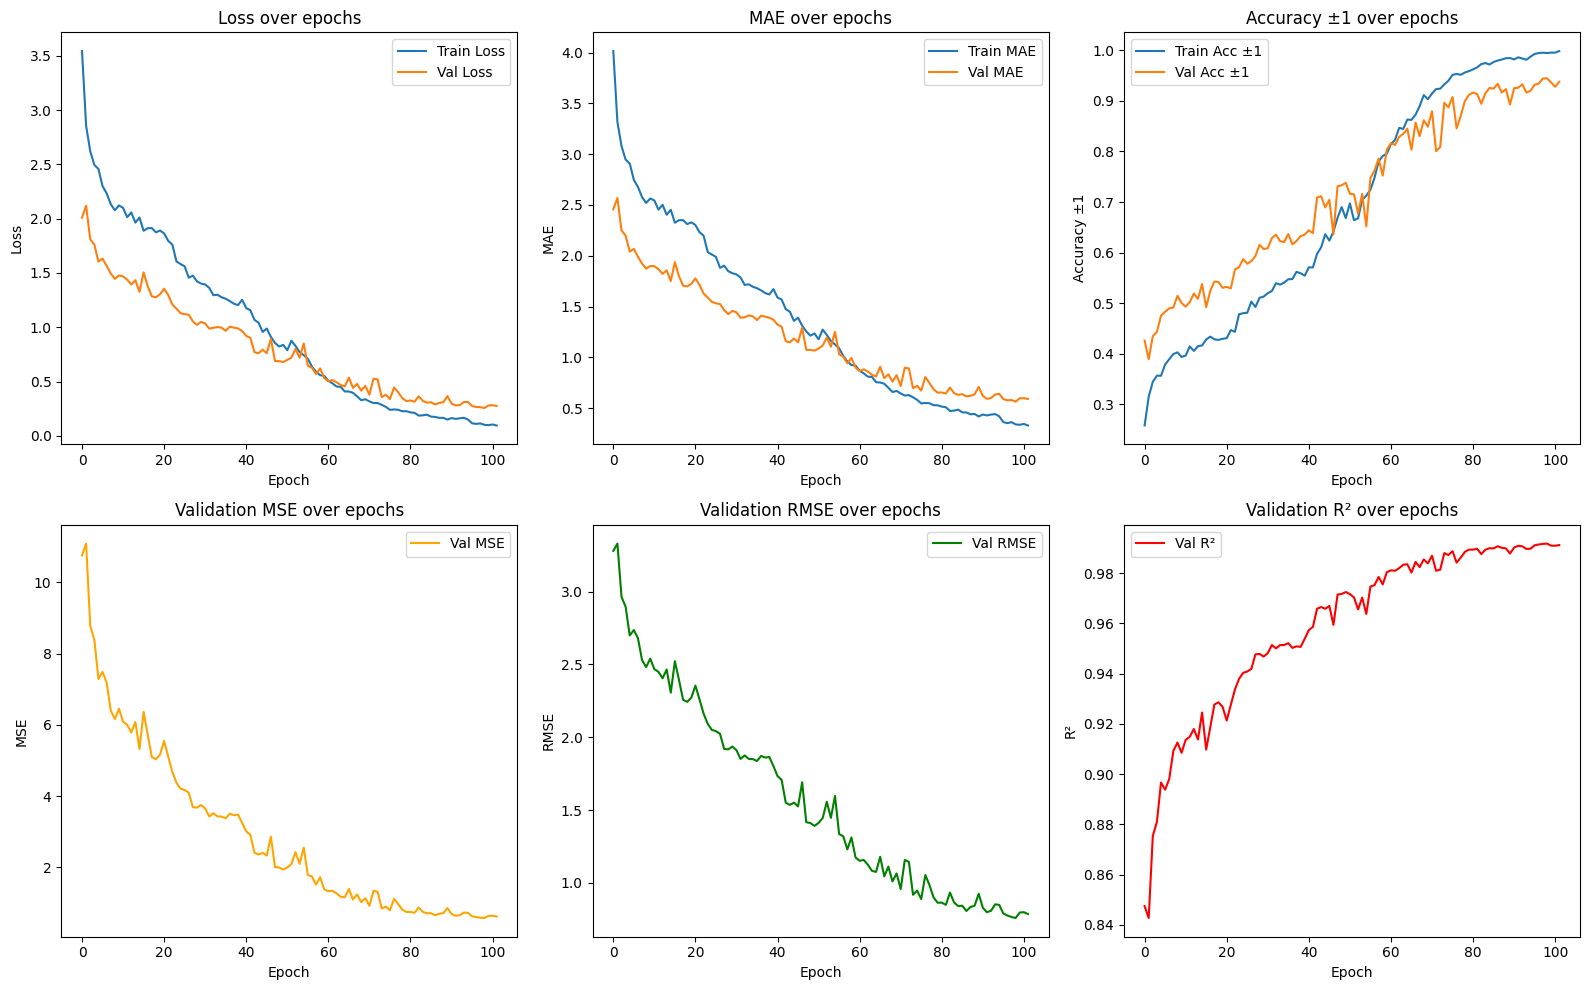

In [13]:
plot_training_history(train_history_all, val_history_all)

## Test the model

Evaluate the model in the test set

In [7]:
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded model from {model_path}")

In [ ]:
def test_model(model, test_loader, criterion, device):
    model.eval()

    running_loss = 0.0
    running_mae = 0.0
    running_acc = 0.0
    total_samples = 0

    all_labels = []
    all_preds = []

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(images)

            loss = criterion(outputs, labels)
            mae = F.l1_loss(outputs, labels)
            acc = accuracy_tolerance(outputs, labels, tol=1)  # tolerance of 1

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            running_mae += mae.item() * batch_size
            running_acc += acc * batch_size
            total_samples += batch_size

            all_labels.append(labels.cpu())
            all_preds.append(outputs.cpu())

            avg_loss = running_loss / total_samples
            avg_mae = running_mae / total_samples
            avg_acc = running_acc / total_samples
            test_bar.set_postfix(loss=avg_loss, MAE=avg_mae, acc=f"{avg_acc*100:.2f}%")

    loss = running_loss / total_samples
    mae = running_mae / total_samples
    acc = running_acc / total_samples

    all_labels = torch.cat(all_labels).squeeze()
    all_preds = torch.cat(all_preds).squeeze()   

    mse = F.mse_loss(all_preds, all_labels)    
    rmse = torch.sqrt(mse).item()

    ss_res = torch.sum((all_labels - all_preds) ** 2)
    ss_tot = torch.sum((all_labels - torch.mean(all_labels)) ** 2)
    r2 = 1 - ss_res / ss_tot
    r2 = r2.item()


    print(f"\nTest Loss (MSE): {loss:.4f} | Test MAE: {mae:.4f} | Test Acc±1: {acc*100:.2f}% | RMSE: {rmse:.4f} | R²: {r2:.4f}")

    return loss, mae, acc, rmse, r2


In [11]:
best_model_path = 'best_model.pth' 

load_model(model, best_model_path, device)

test_loss, test_mae, test_acc, test_rmse, test_r2 = test_model(model, test_dataloader, loss_fn, device)

Loaded model from best_model.pth


Testing: 100%|██████████| 67/67 [04:36<00:00,  4.13s/it, MAE=0.523, acc=95.02%, loss=0.29] 


Test Loss (MSE): 0.2896 | Test MAE: 0.5233 | Test Acc±1: 95.02% | RMSE: 0.8051 | R²: 0.9890


True count: 26.00, Predicted: 29.70, Error: 3.70


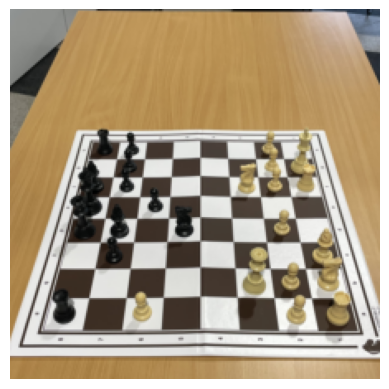

True count: 22.00, Predicted: 25.38, Error: 3.38


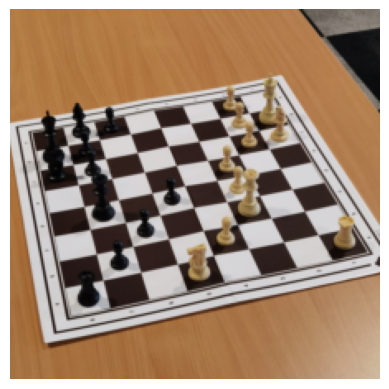

True count: 26.00, Predicted: 29.16, Error: 3.16


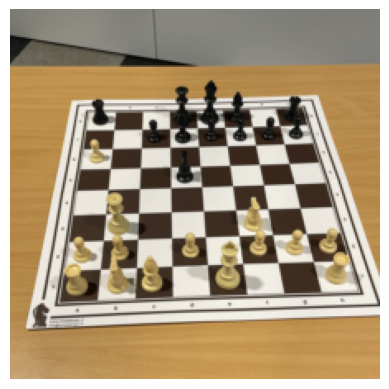

True count: 32.00, Predicted: 28.92, Error: 3.08


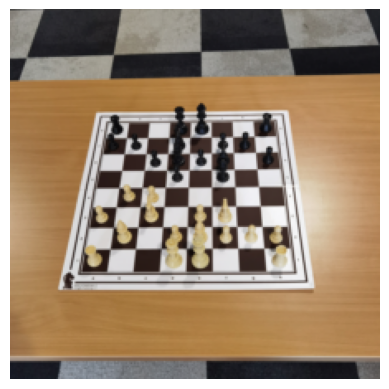

True count: 17.00, Predicted: 19.76, Error: 2.76


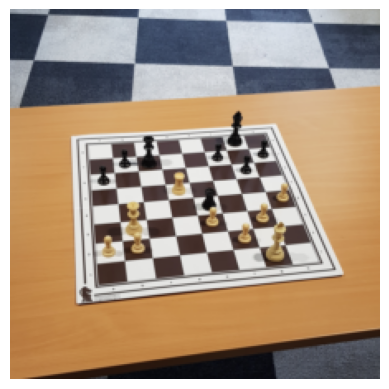

In [12]:
# Function to display an image tensor properly
def show_image(img_tensor):
    # Convert tensor from [C, H, W] to [H, W, C] and convert to numpy
    img = img_tensor.permute(1, 2, 0).numpy()
    
    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    
    # Clip values to valid range [0,1]
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Function to perform qualitative analysis on test dataset
def qualitative_analysis(model, test_dataloader, device, num_examples=5):
    model.eval()
    images_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(images)

            images_list.append(images.cpu())
            labels_list.append(labels.cpu())
            preds_list.append(outputs.cpu())

    # Concatenate all batches
    all_images = torch.cat(images_list)
    all_labels = torch.cat(labels_list).squeeze()
    all_preds = torch.cat(preds_list).squeeze()

    # Calculate absolute errors
    errors = torch.abs(all_preds - all_labels)

    # Sort indices by error descending (worst predictions first)
    sorted_indices = torch.argsort(errors, descending=True)

    # Display the top `num_examples` worst predictions
    for idx in sorted_indices[:num_examples]:
        true_val = all_labels[idx].item()
        pred_val = all_preds[idx].item()
        error_val = errors[idx].item()
        print(f"True count: {true_val:.2f}, Predicted: {pred_val:.2f}, Error: {error_val:.2f}")
        show_image(all_images[idx])

    return all_images, all_labels, all_preds, errors

all_images, all_labels, all_preds, errors = qualitative_analysis(model, test_dataloader, device, num_examples=5)

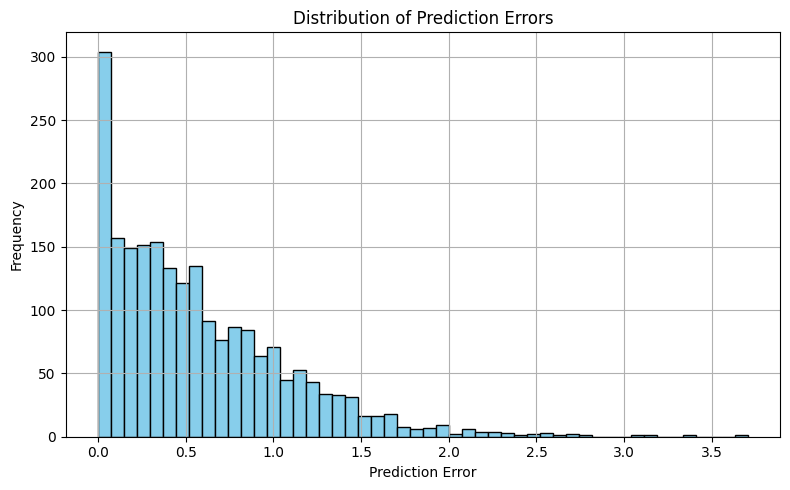

In [27]:
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()